# Xử lí dữ liệu ban đầu và chuẩn bị dữ liệu cho mô hình

Tải tập dữ liệu về từ Kaggle sử dụng Kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hernan4444/anime-recommendation-database-2020")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hernan4444/anime-recommendation-database-2020/versions/7


Kiểm tra xem trong thư mục dữ liệu có những tập dữ liệu nào

In [ ]:
!ls {path}

 anime.csv	 anime_with_synopsis.csv   rating_complete.csv
 animelist.csv	'html folder'		   watching_status.csv


Ta sẽ chọn tập dữ liệu "animelist.csv". Hệ thống đề xuất phim hoạt hình anime sẽ hoạt động dựa trên cơ chế "Collaborative Filtering" - dựa vào những người dùng khác có đặc điểm tương tự để dự đoán người dùng chính thích gì. Ưu điểm của cơ chế này là đơn giản nhưng chính xác cao khi đề xuất anime cho người dùng mà không cần phải "understanding" nó.

In [ ]:
import pandas as pd
import numpy as np
rating_df = pd.read_csv(path + '/animelist.csv', usecols=["user_id", "anime_id", "rating"])
rating_df.head(10)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
5,0,24,9
6,0,2104,0
7,0,4722,8
8,0,6098,6
9,0,3125,9


Ta sẽ thực hiện tìm kiếm những người dùng nào đã đánh giá ít nhất 400 bộ phim anime để có thể xem những user này là một mẫu trong việc thực hiện xây dựng hệ thống đề xuất phim

In [ ]:
# User should rate atleast 400 animies
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()
len(rating_df)

71418114

*   Chuẩn hóa giá trị rating về khoảng [0, 1] để phục vụ cho việc đưa vào mô hình huấn luyện
*   Công thức chuẩn hóa min-max scaling: (x - min_rating) / (max_rating - min_rating), với x là giá trị rating ban đầu

In [ ]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.4047793589172634


Ta tính giá trị trung bình để có cái nhìn tổng quát hơn về xu hướng phân phối của dữ liệu. Giá trị trung bình gần về 0.5, nhận xét rằng dữ liệu có xu hướng phân phối đều

Ta sẽ thực hiện loại bỏ những hàng bị trùng lặp dữ liệu

In [ ]:
# Removing Duplicated Rows
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    # Remove duplicate
    rating_df = rating_df[~duplicates]
# Recheck if exits any duplicate
print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 1 duplicates
> 0 duplicates


Xác định những người dùng và anime phổ biến nhất dựa trên số lượng đánh giá. Phân tích mối quan hệ giữa những người dùng hàng đầu và những anime phổ biến nhất:
*   Xác định ai đã đánh giá anime nào.
*   Tổng điểm đánh giá giữa người dùng và anime.

In [ ]:
g = rating_df.groupby('user_id')['rating'].count()
# top 20 user highest rating
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
# top 20 animes with highest rating
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')
# Assessing the relationship between users and anime
pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

<ipython-input-9-341f00151a8b>:11: FutureWarning: The provided callable <function sum at 0x7dcd6c798670> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)


anime_id,226,1535,1575,2001,2167,4224,5081,5114,6547,6746,9253,9989,10620,11757,15809,16498,19815,20507,22319,30276
user_id,,,,,,,,,,,,,,,,,,,,
20807,1.0,1.0,1.0,1.0,0.8,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0
50485,0.0,0.6,1.0,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,0.9,0.6,1.0,1.0,0.9,1.0,1.0,1.0,0.8
63900,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.8,0.0,0.8,0.8,0.8
68042,0.8,1.0,0.9,1.0,0.7,0.9,1.0,0.9,0.7,0.8,0.9,0.8,0.4,0.4,0.6,0.9,0.3,0.2,0.5,0.9
85472,0.7,0.0,0.0,1.0,0.9,0.9,0.0,0.0,1.0,0.0,0.8,0.0,0.8,0.9,0.8,0.8,0.7,0.7,0.7,0.9
92529,0.9,0.9,1.0,1.0,0.0,0.8,0.0,0.9,0.9,0.0,1.0,0.0,0.8,0.9,0.8,0.9,0.9,0.8,0.8,1.0
122341,0.2,0.3,0.2,0.7,0.4,0.3,0.3,0.8,0.5,0.6,0.7,0.3,0.2,0.1,0.3,0.1,0.4,0.4,0.2,0.6
131988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140590,0.3,0.6,0.5,0.8,0.6,0.8,0.8,0.9,0.5,0.8,0.9,0.7,0.3,0.4,0.6,0.5,0.7,0.7,0.5,0.7


Thực hiện việc mã hóa dữ liệu phân loại (categorical data) để chuyển đổi các giá trị không phải số (user_id và anime_id) thành các giá trị số

In [ ]:
# Encoding categorical data
# Get list of users
user_ids = rating_df["user_id"].unique().tolist()
# Creat dictionary mapped user from user list with index
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
# reverse mapping dictionary
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
# Replace each user_id corresponding with index in dictionary
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 91641, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


Thực hiện việc xáo trộn dữ liệu giảm nguy cơ mô hình học máy bị thiên lệch khi dữ liệu đầu vào có thứ tự cố định

In [ ]:
# Shuffle
# All data will shuffle with same random_state = 73
rating_df = rating_df.sample(frac=1, random_state=73)
# Split data: X for Input and Y for Output of a model
X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

Thực hiện chia tập dữ liệu:
*   Tập huấn luyện (X_train, y_train): Dùng để dạy mô hình học các mối quan hệ giữa user, anime và rating.
*   Tập kiểm tra (X_test, y_test): Dùng để đánh giá hiệu suất của mô hình trên dữ liệu mới (chưa được thấy trong quá trình huấn luyện).

In [ ]:
# Split
# 10k row for test_set
test_set_size = 10000
# size_train_test = size_rating_df - size_test_set
train_indices = rating_df.shape[0] - test_set_size
# Split data corresponding train and test for X & Y
X_train, X_test, y_train, y_test = (X[:train_indices],X[train_indices:],y[:train_indices],y[train_indices:],)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


  Tách tập train và test thành một danh sách có 2 phần tử là 2 mảng:
*   Mảng đầu tiên chứa tất cả dữ liệu trong cột user
*   Mảng thứ hai chứa tất cả dữ liệu trong cột anime

In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Kiểm tra xem môi trường đang chạy là CPU hay GPU. GPU thường nhanh hơn CPU cho các tác vụ tính toán nặng (như học sâu). Hệ thống này sử dụng môi trường chạy là GPU

In [ ]:
import tensorflow as tf

# Flag để chọn CPU
USE_CPU = False

if USE_CPU:
    # Thiết lập lại để chỉ sử dụng CPU
    tf.config.set_visible_devices([], 'GPU')
    print("Using CPU only.")
else:
    # Kiểm tra nếu có GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPUs available: {len(gpus)}")
        for gpu in gpus:
            print(f"Using GPU: {gpu}")
    else:
        print("No GPU detected! Using CPU instead.")

print(f"TensorFlow version: {tf.__version__}")


GPUs available: 1
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow version: 2.17.1


# Xây dựng mô hình

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Tiến hành xây dựng mô hình

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.models import Model

# Build recommend network
def RecommenderNet():
    # embedding vector space size
    embedding_size = 128
    # make sure the IDs are within the Embedding's defined domain.
    max_anime_id = max(X_train_array[0])
    # amount of animes
    n_animes = max_anime_id + 1
    # maps each user ID to a feature vector of dimension embedding_size
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = n_users, output_dim = embedding_size)(user)
    # maps each anime ID to a feature vector of dimension embedding_size
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding', input_dim = n_animes, output_dim = embedding_size)(anime)

    # calculate similarity between user vector and anime by using scalar product
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    # Convert tensor from multidimensional to flat (1-dimensional) form.
    x = Flatten()(x)
    # Fully connected layer with one output
    x = Dense(1, kernel_initializer='he_normal')(x)
    # Normalize the output from the Dense layer to reduce gradient vanish and speed up convergence.
    x = BatchNormalization()(x)
    # Convert output to probability: probability that the user will like the anime or not.
    x = Activation("sigmoid")(x)
    # compile model
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model

model = RecommenderNet()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 128)         │     11,730,048 │ user[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ anime_embedding           │ (None, 1, 128)         │     11,730,048 │ anime[0][0]            │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1, 1)           │              0 │ user_embedding[0][0],  │
│                           │                        │                │ anime_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1)              │              0 │ dot_product[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │              2 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1)              │              4 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1)              │              0 │ batch_normalization_1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,460,102 (89.49 MB)

 Trainable params: 23,460,100 (89.49 MB)

 Non-trainable params: 2 (8.00 B)

* LearningRateScheduler: Tối ưu tốc độ học để mô hình hội tụ nhanh và chính xác hơn. Giảm rủi ro "nhảy quá xa" (overshooting) hoặc "đi quá chậm" (underfitting).  
* ModelCheckpoint: Giảm nguy cơ mất trạng thái mô hình tốt nhất do overfitting.
*   EarlyStopping: Ngăn việc huấn luyện kéo dài không cần thiết, tiết kiệm tài nguyên và giảm rủi ro overfitting.
*   Bộ callback phối hợp để đảm bảo quá trình huấn luyện diễn ra hiệu quả, ổn định, và tiết kiệm


In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

# Learning rate settings
start_lr = 0.00001      # Init leaning rate
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000


rampup_epochs = 5       # Number of epochs to speed up learning rate from start_lr to max_lr
sustain_epochs = 0      # Number of epochs to maintain learning rate at max_lr
exp_decay = .8          # Exponential decay factor for the learning rate after the peak.
# Adjust learning rate for each epoch to optimize learning efficiency
def lrfn(epoch):
    # In the first epochs, the learning rate increases linearly from start_lr to max_lr.
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    # The learning rate is kept constant at max_lr for a number of epochs.
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    # learning rate decreases exponentially with respect to min_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

# Automatically update learning rate according to lrfn function in each epoch
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
# Save the best model weights (based on val_loss value).
checkpoint_filepath = './weights.weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)
# Stop training early if the model does not improve
early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,
]


Thực hiện huấn luyện mô hình

In [ ]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)
# Reload best weights
model.load_weights(checkpoint_filepath)

Epoch 1/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 77s 10ms/step - loss: 0.7253 - mae: 0.3704 - mse: 0.1719 - val_loss: 0.7069 - val_mae: 0.3700 - val_mse: 0.1654 - learning_rate: 1.0000e-05
Epoch 2/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 77s 9ms/step - loss: 0.6971 - mae: 0.3650 - mse: 0.1591 - val_loss: 0.6789 - val_mae: 0.3651 - val_mse: 0.1519 - learning_rate: 1.8000e-05
Epoch 3/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - loss: 0.6570 - mae: 0.3463 - mse: 0.1399 - val_loss: 0.5815 - val_mae: 0.2828 - val_mse: 0.1081 - learning_rate: 2.6000e-05
Epoch 4/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.5605 - mae: 0.2633 - mse: 0.0981 - val_loss: 0.5426 - val_mae: 0.2474 - val_mse: 0.0933 - learning_rate: 3.4000e-05
Epoch 5/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step - loss: 0.5261 - mae: 0.2318 - mse: 0.0854 - val_loss: 0.5201 - val_mae: 0.2254 - val_mse: 0.0849 - learning_rate: 4.2000e-05
Epoch 6/20
7141/7141 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 0.5037 - mae: 0.2106 - mse:

 Mô hình học tốt trên tập huấn luyện và không bị overfitting

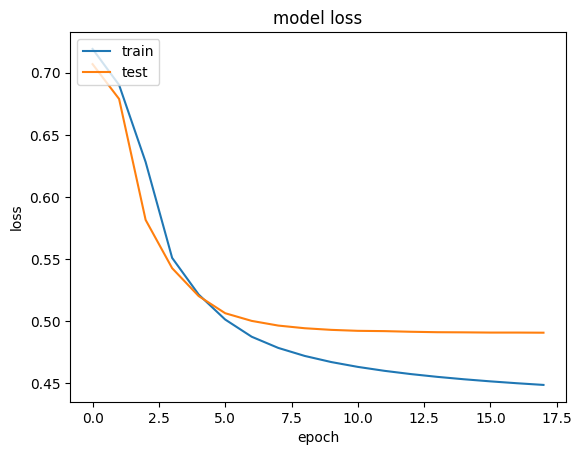

In [ ]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Trích xuất và chuẩn hóa trọng số weight của người dùng và anime trong hệ thống gợi ý. Việc chuẩn hóa này giúp cho việc tính cosine similar dễ dàng phục vụ cho việc phân tích mối tương quan giữa các trường dữ liệu

In [ ]:
# Extract and normalize weights from an embedding layer in the model.
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    # Calculate the Euclidean norm (L2 norm) of each embedding vector
    # Euclidean (L2 norm): sqrt(sqr(x1-x2) + sqr(y1-y2))
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [ ]:
df = pd.read_csv(path + '/anime.csv')
df = df.replace("Unknown", np.nan)

In [ ]:
# Fixing Names: Returns the anime name (English name or original name)
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')

    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))
# Sort dataframe by anime score from high to low
df.sort_values(by=['Score'],inplace=True,ascending=False,kind='quicksort',na_position='last')

df = df[["anime_id", "eng_version","Score", "Genres", "Episodes","Type", "Premiered", "Members"]]

In [ ]:
# Return dataframe based on the ID or English name of the anime.
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [ ]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
INPUT_DIR = path
sypnopsis_df = pd.read_csv(INPUT_DIR + '/anime_with_synopsis.csv', usecols=cols)
# Retrieve anime synopsis based on MAL_ID or anime name.
def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

# Task 1: Tìm kiếm anime tương tự

In [ ]:
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        # access anime id
        index = getAnimeFrame(name).anime_id.values[0]
        # map anime id with encoded id
        encoded_index = anime2anime_encoded.get(index)
        # weight using Euclidean L2 norm
        weights = anime_weights
        # Caculate cosine similiraty
        dists = np.dot(weights, weights[encoded_index])    # similiraty point
        sorted_dists = np.argsort(dists)                   # arrange

        n = n + 1

        if neg:
            closest = sorted_dists[:n]      # least similar
        else:
            closest = sorted_dists[-n:]     # most similar

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest

        rindex = df
        # Building data frame for result
        SimilarityArr = []
        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,"similarity": similarity,"genre": genre,'sypnopsis': sypnopsis})


        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [ ]:
find_similar_animes('Dragon Ball Z', n=5, neg=False)

animes closest to Dragon Ball Z


,name,similarity,genre,sypnopsis
4,Dragon Ball,0.980308,"Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Gokuu Son is a young boy who lives in the woods all alone—that is, until a girl named Bulma runs into him in her search for a set of magical objects called the ""Dragon Balls."" Since the artifacts are said to grant one wish to whoever collects all seven, Bulma hopes to gather them and wish for a perfect boyfriend. Gokuu happens to be in possession of a dragon ball, but unfortunately for Bulma, he refuses to part ways with it, so she makes him a deal: he can tag along on her journey if he lets her borrow the dragon ball's power. With that, the two set off on the journey of a lifetime. They don't go on the journey alone. On the way, they meet the old Muten-Roshi and wannabe disciple Kuririn, with whom Gokuu trains to become a stronger martial artist for the upcoming World Martial Arts Tournament. However, it's not all fun and games; the ability to make any wish come true is a powerful one, and there are others who would do much worse than just wishing for a boyfriend. To stop those who would try to abuse the legendary power, they train to become stronger fighters, using their newfound strength to help the people around them along the way."
3,Dragon Ball GT,0.925363,"Action, Sci-Fi, Adventure, Comedy, Super Power, Magic, Fantasy, Shounen","Emperor Pilaf finally has his hands on the Black Star Dragon Balls after years of searching, which are said to be twice as powerful as Earth's normal ones. Pilaf is about to make his wish for world domination when he is interrupted by Gokuu Son. As a result, Pilaf flubs his wish and accidentally turns Gokuu back into a child. After the wish is granted, the Black Star Dragon Balls scatter across the galaxy. However, Gokuu discovers that they will cause the Earth to explode unless they are all brought back within a year. Uniting with his granddaughter Pan and a young adult Trunks, Gokuu sets off on an adventure through the universe to find the Black Star Dragon Balls and save his planet from destruction."
2,Naruto,0.820448,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."
1,Dragon Ball Z Kai,0.818219,"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power","Five years after the events of Dragon Ball, martial arts expert Gokuu is now a grown man married to his wife Chi-Chi, with a four-year old son named Gohan. While attending a reunion on Turtle Island with his old friends Master Roshi, Krillin, Bulma and others, the festivities are interrupted when a humanoid alien named Raditz not only reveals the truth behind Gokuu's past, but kidnaps Gohan as well. With Raditz displaying power beyond anything Gokuu has seen before, he is forced to team up with his old nemesis, Piccolo, in order to rescue his son. But when Gokuu and Piccolo reveal the secret of the seven mystical wish-granting Dragon Balls to Raditz, he informs the duo that there is more of his race, the Saiyans, and they won’t pass up an opportunity to seize the power of the Dragon Balls for themselves. These events begin the saga of Dragon Ball Kai , a story that finds Gokuu and his friends and family constantly defending the galaxy from increasingly more powerful threats. Bizarre, comical, heartwarming and threatening characters come together in a series 

In [ ]:
find_similar_animes('Your Name.', n=5, neg=False)

animes closest to Your Name.


,name,similarity,genre,sypnopsis
4,A Silent Voice,0.948182,"Drama, School, Shounen","s a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye. Now in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends. Koe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
3,Your Lie in April,0.742148,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. Two years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. Based on the manga series of the same name, Shigatsu wa Kimi no Uso approaches the story of Kousei's recovery as he discovers that music is more than playing each note perfectly, and a single melody can bring in the fresh spring air of April."
2,ERASED,0.731868,"Mystery, Psychological, Supernatural, Seinen","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
1,Re:ZERO -Starting Life in Another World-,0.703892,"Psychological, Drama, Thriller, Fantasy","hen Subaru Natsuki leaves the convenience store, the last thing he expects is to be wrenched from his everyday life and dropped into a fantasy world. Things aren't looking good for the bewildered teenager; however, not long after his arrival, he is attacked by some thugs. Armed with only a bag of groceries and a now useless cell phone, he is quickly beaten to a pulp. Fortunately, a mysterious beauty named Satella, in hot pursuit after the one who stole her insignia, happens upon Subaru and saves him. In order to thank the honest and kindhearted girl, Subaru offers to help in her search, and later that night, he even finds the whereabouts of that which she seeks. But unbeknownst to them, a much darker force stalks the pair from the shadows, and just minutes after locating the insignia, Subaru and Satella are brutally murdered. However, Subaru immediately reawakens to a familiar scene—confronted by the same group of thugs, meeting Satella all over again—the enigma deepens as history inexplicably repeats itself."
0,anohana:The Flower We Saw That Day,0.697626,"Slice of Life, Supernatural, Drama","

In [ ]:
find_similar_animes('Sword Art Online', n=5, neg=False)

animes closest to Sword Art Online


,name,similarity,genre,sypnopsis
4,Sword Art Online II,0.893588,"Action, Game, Adventure, Romance, Fantasy","ar after escaping Sword Art Online, Kazuto Kirigaya has been settling back into the real world. However, his peace is short-lived as a new incident occurs in a game called Gun Gale Online, where a player by the name of Death Gun appears to be killing people in the real world by shooting them in-game. Approached by officials to assist in investigating the murders, Kazuto assumes his persona of Kirito once again and logs into Gun Gale Online, intent on stopping the killer. Once inside, Kirito meets Sinon, a highly skilled sniper afflicted by a traumatic past. She is soon dragged in his chase after Death Gun, and together they enter the Bullet of Bullets, a tournament where their target is sure to appear. Uncertain of Death Gun's real powers, Kirito and Sinon race to stop him before he has the chance to claim another life. Not everything goes smoothly, however, as scars from the past impede their progress. In a high-stakes game where the next victim could easily be one of them, Kirito puts his life on the line in the virtual world once more."
3,"No Game, No Life",0.850796,"Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
2,Attack on Titan,0.799093,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1,Akame ga Kill!,0.786551,"Action, Adventure, Drama, Fantasy, Shounen","Night Raid is the covert assassination branch of the Revolutionary Army, an uprising assembled to overthrow Prime Minister Honest, whose avarice and greed for power has led him to take advantage of the child emperor's inexperience. Without a strong and benevolent leader, the rest of the nation is left to drown in pov

In [ ]:
find_similar_animes('Black Clover', n=5, neg=False)

animes closest to Black Clover


,name,similarity,genre,sypnopsis
4,Boruto:Naruto Next Generations,0.751769,"Action, Adventure, Super Power, Martial Arts, Shounen","Following the successful end of the Fourth Shinobi World War, Konohagakure has been enjoying a period of peace, prosperity, and extraordinary technological advancement. This is all due to the efforts of the Allied Shinobi Forces and the village's Seventh Hokage, Naruto Uzumaki. Now resembling a modern metropolis, Konohagakure has changed, particularly the life of a shinobi. Under the watchful eye of Naruto and his old comrades, a new generation of shinobi has stepped up to learn the ways of the ninja. Boruto Uzumaki is often the center of attention as the son of the Seventh Hokage. Despite having inherited Naruto's boisterous and stubborn demeanor, Boruto is considered a prodigy and is able to unleash his potential with the help of supportive friends and family. Unfortunately, this has only worsened his arrogance and his desire to surpass Naruto which, along with his father's busy lifestyle, has strained their relationship. However, a sinister force brewing within the village may threaten Boruto's carefree life. New friends and familiar faces join Boruto as a new story begins in Boruto: Naruto Next Generations ."
3,Super Dragon Ball Heroes,0.605087,"Action, Comedy, Super Power, Martial Arts, Fantasy, Shounen","In May 2018, V-Jump announced a promotional anime for Dragon Ball Heroes , a Japanese arcade and trading card game that has never been released in the West. The anime is expected to be short and it is not expected to broadcast on TV. It will adapt the game's Prison Planet Arc, fully detailed in the Heroes manga published in Saikyou Jump, which has never been published in English. The first episode will debut July 1, 2018 at Aeon Lake Town."
2,Radiant,0.563441,"Action, Adventure, Fantasy, Magic","Nemeses—powerful and mysterious demonic entities that fall from the sky and vaporize anything they touch. The only ones who can combat these creatures are Sorcerers, those who have survived an encounter with a Nemesis but were infected in the process. Seth, a Sorcerer from Pompo Hills, sets out on an adventure to exterminate all these Nemeses. Accompanying him are Doc and Mélie, fellow Sorcerers who share his ideal. Their main objective is to bring about a world where Sorcerers are no longer persecuted for being infected, and to that end, desire to destroy the source of the Nemeses themselves: the mythical Radiant."
1,Jujutsu Kaisen (TV),0.560954,"Action, Demons, Supernatural, School, Shounen","Idly indulging in baseless paranormal activities with the Occult Club, high schooler Yuuji Itadori spends his days at either the clubroom or the hospital, where he visits his bedridden grandfather. However, this leisurely lifestyle soon takes a turn for the strange when he unknowingly encounters a cursed item. Triggering a chain of supernatural occurrences, Yuuji finds himself suddenly thrust into the world of Curses—dreadful beings formed from human malice and negativity—after swallowing the said item, revealed to be a finger belonging to the demon Sukuna Ryoumen, the ""King of Curses."" Yuuji experiences first-hand the threat these Curses pose to society as he discovers his own newfound powers. Introduced to the Tokyo Metropolitan Jujutsu Technical High School, he begins to walk down a path from which he cannot return—the path of a Jujutsu sorcerer."
0,Fire Force,0.559294,"Action, Supernatural, Shounen","Spontaneous Human Combustion: a chaotic phenomenon that has plagued humanity for years, randomly transforming ordinary people into flaming, violent creatures known as Infernals. While Infernals make up the first-generation accounts of Human Combustion, the second and third generations became known as pyrokinetics—people gifted with the ability to manipulate and control their flames while remaining human. To combat the Infernal threat and discover the cause, the Tokyo Armed Forces, Fire Defense Agency, and Ho

In [ ]:
find_similar_animes('Death Note', n=5, neg=False)

animes closest to Death Note


,name,similarity,genre,sypnopsis
4,Attack on Titan,0.849309,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
3,Code Geass:Lelouch of the Rebellion,0.819960,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
2,Code Geass:Lelouch of the Rebellion R2,0.814397,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
1,Fullmetal Alchemist:Brotherhood,0.786530,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail""

# Task 2: Tìm kiếm người dùng tương tự

Chọn người dùng ngẫu nhiên để kiểm tra đề xuất những người dùng tương tự của hệ thống

In [ ]:
print('> picking up random user')
# User rating of animes
ratings_per_user = rating_df.groupby('user_id').size()
# Pick random user from rating less than 500
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 213102


Tìm những người dùng tương tự dựa trên các đặc trưng hoặc các đánh giá của họ

In [ ]:
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        # ID user
        index = item_input
        # Map ID user with ID encoded
        encoded_index = user2user_encoded.get(index)
        # weight using Euclidean L2 norm
        weights = user_weights
        # Caculate cosine similiraty
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n + 1
        # Arrange similar base neg_flag
        if neg:
            closest = sorted_dists[:n]      # least similar
        else:
            closest = sorted_dists[-n:]     # most similar

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest

        rindex = df
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]
            # if id is interger, decode the id
            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id,"similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        # result
        return Frame

    except:
        print('{}!, Not Found in User list'.format(name))

Tìm kiếm và lọc danh sách người dùng có độ tương tự cao nhất với một người dùng được chọn ngẫu nhiên

In [ ]:
similar_users = find_similar_users(int(random_user),n=5,neg=False)
# Only keep users with similarity greater than 0.4
similar_users = similar_users[similar_users.similarity > 0.4]
# remove root user from list
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #213102


,similar_users,similarity
4,113673,0.505581
3,262053,0.474904
2,44207,0.456524
1,198391,0.447481
0,157278,0.442745


Phân tích sở thích của người dùng dựa trên các thể loại (genres) của anime mà họ đã đánh giá cao, đồng thời tạo một biểu đồ từ (word cloud) để trực quan hóa các thể loại yêu thích.

In [ ]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt
# Create and display a word cloud based on the frequency of anime genres.
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)

    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
# Get a list of favorite genres from a dataframe
def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)

        genres_list = []
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1
        if plot:
            showWordCloud(all_genres)

        return genres_list

# Returns information about users' most favorite anime based on ratings.
def get_user_preferences(user_id, plot=False, verbose=0):
    # Get anime that users have rated.
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    # Keep anime with ratings higher than 75 percentile of the ratings.
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    # Sort anime in descending order of rating.
    top_animes_user = (animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values)
    # Filter DataFrame df to get only animes in top_animes_user list
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    # Keep only the two columns eng_version and Genres
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]
    # Print information
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(user_id, len(animes_watched_by_user),animes_watched_by_user['rating'].mean(),))
        print('> preferred genres')
    # Create a word cloud that shows users' favorite categories.
    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows

> User #213102 has rated 175 movies (avg. rating = 0.8)
> preferred genres


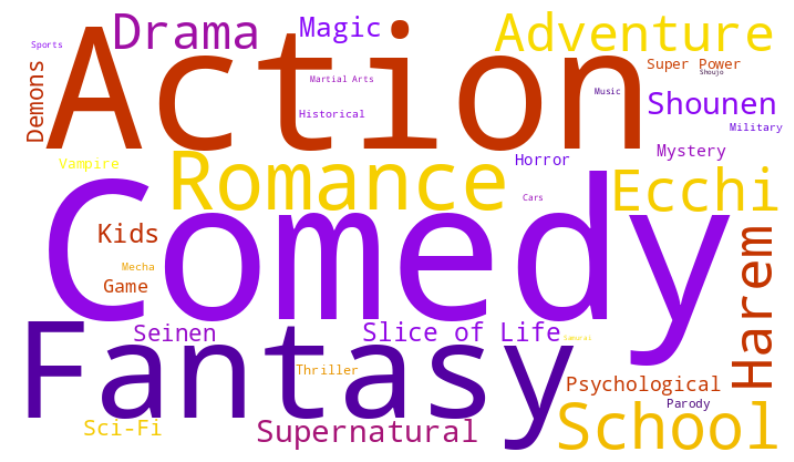

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
5683,Steins;Gate,"Thriller, Sci-Fi"
9886,A Silent Voice,"Drama, School, Shounen"
11308,Your Name.,"Romance, Supernatural, School, Drama"
16245,Kaguya-sama:Love is War Season 2,"Comedy, Psychological, Romance, School, Seinen"


In [ ]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

# Task 3: Đề xuất anime cho người dùng

Hệ thống sẽ đưa ra danh sách các anime được đề xuất dựa trên sở thích của những người dùng tương tự với người dùng đầu vào

In [ ]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []       # Preferred anime results
    anime_list = []               # Stores a list of anime that similar users have rated highly.
    # Get anime list from similar users
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), verbose=0)
        # Remove anime that the input user (user_pref) has watched
        pref_list = pref_list[~ pref_list.eng_version.isin(user_pref.eng_version.values)]
        anime_list.append(pref_list.eng_version.values)
    # count appearance of anime in list
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Building detailed information for anime
    for i, anime_name in enumerate(sorted_list.index):
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance(anime_name, str):
            try:
                frame = getAnimeFrame(anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                sypnopsis = getSypnopsis(int(anime_id))
                recommended_animes.append({"n": n_user_pref,"anime_name": anime_name,"Genres": genre,"sypnopsis": sypnopsis})
            except:
                pass

    return pd.DataFrame(recommended_animes)

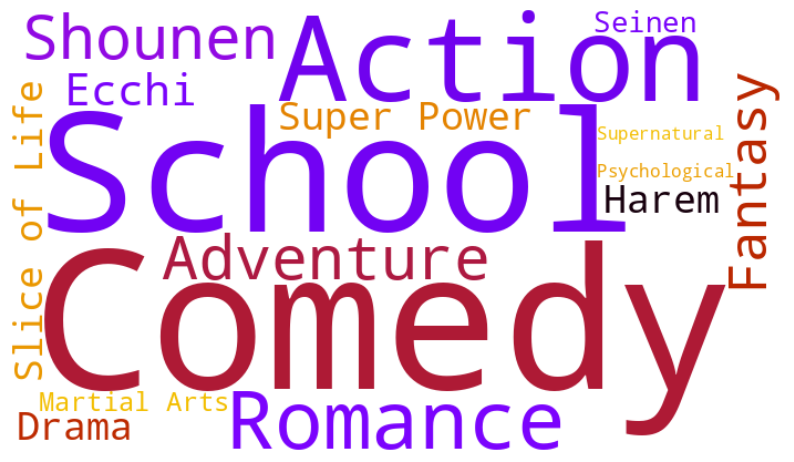


> Top recommendations for user: 213102


,n,anime_name,Genres,sypnopsis
0,5,Prison School,"Comedy, Ecchi, Romance, School, Seinen","ocated on the outskirts of Tokyo, Hachimitsu Private Academy is a prestigious all-girls boarding school, famous for its high-quality education and disciplined students. However, this is all about to change due to the revision of the school's most iconic policy, as boys are now able to enroll as well. At the start of the first semester under this new decree, a mere five boys have been accepted, effectively splitting the student body into a ratio of two hundred girls to one boy. Kiyoshi, Gakuto, Shingo, Andre, and Jo are quickly cast away without having a chance to make any kind of a first impression. Unable to communicate with their fellow female students, the eager boys set their sights on a far more dangerous task: peeping into the girls' bath! It's only after their plan is thoroughly decimated by the infamous Underground Student Council that the motley crew find their freedom abruptly taken from them, as they are thrown into the school's prison with the sentence of an entire month as punishment. Thus begins the tale of the boys' harsh lives in Prison School, a righteous struggle that will ultimately test the bonds of friendship and perverted brotherhood."
1,4,Is It Wrong to Try to Pick Up Girls in a Dungeon?,"Action, Adventure, Comedy, Romance, Fantasy","fe in the bustling city of Orario is never dull, especially for Bell Cranel, a naïve young man who hopes to become the greatest adventurer in the land. After a chance encounter with the lonely goddess, Hestia, his dreams become a little closer to reality. With her support, Bell embarks on a fantastic quest as he ventures deep within the city's monster-filled catacombs, known only as the ""Dungeon."" Death lurks around every corner in the cavernous depths of this terrifying labyrinth, and a mysterious power moves amidst the shadows. Even on the surface, survival is a hard-earned privilege. Indeed, nothing is ever certain in a world where gods and humans live and work together, especially when they often struggle to get along. One thing is for sure, though: a myriad of blunders, triumphs and friendships awaits the dauntlessly optimistic protagonist of this herculean tale."
2,4,Naruto,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."
3,4,That Time I Got Reincarnated as a Slime,"Fantasy, Shounen","Thirty-seven-year-old Satoru Mikami is a typical corporate worker, who is perfectly content with his monotonous lifestyle in Tokyo, other than failing to nail down a girlfriend even once throughout his life. In the midst of a casual encounter with his colleague, he falls victim to a random assailant on the streets and is stabbed. However, while succumbing to his injuries, a peculiar voice echoes in his mind, and recites a bunch of commands which the dying man cannot make sense of. When Satoru regains consciousness, he discovers that he has reincarnated as a goop of slime in an unfamiliar realm. In doing so, he acquires newfound skills—notably, the power to devour anything and mimic its appearance and abilities. He then stumbles upon the sealed Catastrophe-level monster ""Storm Dragon"" Veldora who had been sealed away for the past 300 years for devastating a town to ashes. Sympathetic to his predicament, Satoru befriends him, promising to assist i

In [ ]:
# Recommed movie for user 213102 from similar user list
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

# Task 4: Dự đoán rating của người dùng với những anime chưa xem

In [ ]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)
# Get list of anime not watch by user
animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df[~df["anime_id"].isin(animes_watched_by_user.anime_id.values)]
# Encode anime_id
anime_not_watched = list(set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys())))
anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]
# Create an array user_anime_array of pairs (user_id, anime_id) to predict the rating.
user_encoder = user2user_encoded.get(random_user)
user_anime_array = np.hstack(([[user_encoder]] * len(anime_not_watched), anime_not_watched))
user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
# Random user rating prediction model for all unwatched anime
ratings = model.predict(user_anime_array).flatten()
# Top 10 animes highest rating
top_ratings_indices = (-ratings).argsort()[:10]
recommended_anime_ids = [anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices]
# Create a list of results
Results = []
top_rated_ids = []
for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])

    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.anime_id == id_)
            name = df[condition]['eng_version'].values[0]
            genre = df[condition].Genres.values[0]
            score = df[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue

        Results.append({"name": name,"pred_rating": rating,"genre": genre,'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)
# Arrange
Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results

Showing recommendations for user: 213102
535/535 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre,sypnopsis
7,Afro Samurai the Movie,0.972563,"Action, Adventure, Samurai",movie adaptation of the TV series.
3,Dogtanian and the Three Muskehounds,0.965937,"Adventure, Historical","The story begins with the arrival of a brave young boy in Paris. His ambition is to join the glorious Imperial Guards, but fierce competition and the minimum age requirement hinder him from joining. The boy then challenges the well-known Three Musketeers in order to demonstrate his excellent skills with the sword. However, at the very moment the fight begins, a power-hungry group cuts in. Realizing their wicked intention, the boy D'artagnan and the Three Musketeers quickly cooperate and defeat them. This is the beginning of their friendship and commitment to fight conspiracy."
9,Yamada-kun to 7-nin no Majo: Mou Hitotsu no Suzaku-sai,0.949308,"Comedy, Romance, School, Shounen","Shiraishi Urara is the top student in her school. One day, due to an accidental kiss, Urara finds herself in the body of the school delinquent, Yamada Ryuu! In trying to switch back to their own bodies, Urara and Ryuu discover that kissing causes them to switch bodies, which leads to their discovery that there are 7 witches in their school. They soon try to uncover the identities of the 7 witches... (Source: AniDB)"
6,Dramaturgy,0.942870,Music,"original song by Eve, sung by Hatsune Miku, animated by Mah. Eve's self-cover uses the same animated footage and was released on October 11, 2017. Eve included his self-cover MV on his own self-made record label harapeco records 's CD+DVD release on December 13, 2017 as a part of his ""Bunka"" album."
4,The Secret About That Girl,0.942833,"Music, Romance","original song by Eve, sung by Hatsune Miku, animated by Okamoto and TriF Studio. Eve's self-cover uses the same animated footage and was released on July 15, 2017. Eve included his self-cover MV on his own self-made record label harapeco records 's CD+DVD release on December 13, 2017 as a part of his ""Bunka"" album."
0,Doraemon,0.941804,"Adventure, Comedy, Fantasy, Kids, Shounen","Nobita Nobi is so hapless that his 22nd century decendants are still impoverished as a result of his 20th century bumbling. In a bid to raise their social status, their servant, a robotic cat named Doraemon, decides to travel back in time and guide Nobita on the proper path to fortune. Unfortunately Doraemon, a dysfunctional robot that the familly acquired by accident (but chose to keep nonetheless), isn't much better off than Nobita. The robot leads Nobita on many adventures, and while Nobita's life certainly is more exciting with the robot cat from the future, it is questionable if it is in fact better in the way that Doraemon planned. (Source: AniDB) Note: The series has been poorly preserved, and never released on any format, nor has it ever been re-aired. Nearly all the footage within the series (except for the opening and closing credits) was destroyed in an accidental fire sometime after the series was cancelled. Surviving reels from the show are occasionally shown at Doraemon fan conventions in Japan. In addition, the audio of several episodes still survives. Still images from episodes 1 and 24 exists. (Source: Wikipedia)"
5,Ramayana:The Legend of Prince Rama,0.941315,Adventure,"heatrical anime movie of the original story of the epic Indian classical ""Ramayana"" and a joint production between Japan and India. Prince Rama, one of the four Princes of Ayodhya, will be expelled from the palace through a conspiracy. Rama is banished to the forest for 14 years. A girl named Sita and Lakshman, Rama's brother, go with him into the forest. Ravana, the King of Demons, falls in love with Sita and kidnaps her. In order to save his love, Rama goes to Lanka with the help of an army of monkeys and friends of the forest. A feature film based on a story of true love, friendship, and trust, this anime is about 2 hours and 15 minutes long, with musical elements from Indian cinemas in between."


In [ ]:
model.save('anime_model.h5')